In [1]:
import geopandas as gpd
import pandas as pd

import mapillary as mly

import glob

from datetime import datetime



### osm-netzwerk einlesen

In [2]:
#set_date = "251010" 
#set_date = "251022" 
#set_date = "251115" 
#set_date = "251215" 
set_date = "260129" 


cycleways=gpd.read_parquet(f"processed_osm_files/processed_cycleways_germany_{set_date}.parquet")
motorways=gpd.read_parquet(f"processed_osm_files/processed_motorways_germany_251215.parquet") # dont need to update this file every time

print("number of cycleways:", len(cycleways))
print("number of motorways:", len(motorways))

number of cycleways: 5549215
number of motorways: 70011


In [3]:
cycleways.head()

,osm_id,highway,bicycle,bicycle_forward,bicycle_backward,cycleway,cycleway_left,cycleway_right,cycleway_both,cycleway_lane,...,maxspeed,maxspeed_conditional,maxspeed_backward,maxspeed_forward,maxspeed_type,name,ref,surface,width,geometry
0,99,tertiary,None,None,None,None,None,no,None,None,...,None,None,None,None,None,None,None,asphalt,None,"LINESTRING (11.36639 48.17411, 11.36643 48.174..."
1,104,unclassified,None,None,None,None,None,None,no,None,...,50,None,None,None,None,Münzmeisterstraße,None,asphalt,None,"LINESTRING (13.74142 51.02366, 13.74139 51.023..."
2,105,residential,None,None,None,None,None,None,no,None,...,30,None,None,None,None,Altpestitz,None,sett,None,"LINESTRING (13.73698 51.01663, 13.73643 51.016..."
3,107,residential,None,None,None,None,None,None,no,None,...,30,None,None,None,None,Trienter Straße,None,asphalt,None,"LINESTRING (13.73507 51.01914, 13.73505 51.019..."
4,110,residential,None,None,None,None,None,None,no,None,...,50,None,None,None,sign,Heinrich-Greif-Straße,None,concrete:plates,None,"LINESTRING (13.74296 51.02871, 13.74295 51.028..."


In [4]:
cycleways.columns

Index(['osm_id', 'highway', 'bicycle', 'bicycle_forward', 'bicycle_backward',
       'cycleway', 'cycleway_left', 'cycleway_right', 'cycleway_both',
       'cycleway_lane', 'cycleway_track', 'cycleway_opposite',
       'cycleway_shared_lane', 'sidewalk_right_bicycle',
       'sidewalk_left_bicycle', 'sidewalk_both_bicycle', 'maxspeed',
       'maxspeed_conditional', 'maxspeed_backward', 'maxspeed_forward',
       'maxspeed_type', 'name', 'ref', 'surface', 'width', 'geometry'],
      dtype='object')

In [5]:
filtered_cycleways = cycleways[
    (cycleways["bicycle"].isin(["designated"])) |
    (cycleways["bicycle_backward"].isin(["designated"])) |
    (cycleways["bicycle_forward"].isin(["designated"])) |
    (cycleways["highway"].isin(["cycleway"])) |
    (cycleways["cycleway"].notnull() & (cycleways["cycleway"] != "no")) |
    (cycleways["cycleway_left"].notnull() & (cycleways["cycleway_left"] != "no")) |
    (cycleways["cycleway_right"].notnull() & (cycleways["cycleway_right"] != "no")) |
    (cycleways["cycleway_both"].notnull() & (cycleways["cycleway_both"] != "no")) |
    (cycleways["cycleway_lane"].notnull() & (cycleways["cycleway_lane"] != "no")) |
    (cycleways["cycleway_track"].notnull() & (cycleways["cycleway_track"] != "no")) |
    # (cycleways["sidewalk_bicycle"].isin(["designated"])) |  TODO: add "sidewalk:bicycle" in ini file
    (cycleways["sidewalk_right_bicycle"].isin(["designated"])) |
    (cycleways["sidewalk_left_bicycle"].isin(["designated"])) |
    (cycleways["sidewalk_both_bicycle"].isin(["designated"])) 
]
len(filtered_cycleways)

784137

In [6]:
#filtered_cycleways[::10].plot()

In [7]:
# # Lade lk
# lk = gpd.read_file("https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/refs/heads/main/4_kreise/1_sehr_hoch.geo.json")
# #lk[lk.NAME_3 == "Ravensburg"].plot()

# sel_lk = lk[lk.NAME_3 == "Berlin"]
# sel_lk=sel_lk.to_crs(filtered_cycleways.crs)
# filtered_cycleways_lk = filtered_cycleways.clip(sel_lk)

# filtered_cycleways_lk.plot()

In [8]:
#motorways.plot()

In [9]:
filtered_cycleways_proj = filtered_cycleways.to_crs(25833)
filtered_cycleways_proj["length_m"] = filtered_cycleways_proj.geometry.length
#filtered_cycleways_proj[["osm_id", "length_m"]]

total_km = filtered_cycleways_proj.length_m.sum() / 1000
print(f"Gesamtlänge der gefilterten 'Radinfra': {total_km:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".") + " km")

Gesamtlänge der gefilterten 'Radinfra': 139.424,84 km


In [10]:
#filtered_cycleways.highway.value_counts()

### mapillary traffic signs einlesen

In [ ]:


## TRAFFFIC SIGNS
# https://www.mapillary.com/developer/api-documentation/traffic-signs?locale=


### EINLESEN

# Find all parquet files in the tile_cache folder (per state)
parquet_files = glob.glob("../../output/mapillary_traffic-signs_*.parquet")
# Extract and print the dates from the filenames
dates = [f.split("_")[-1].replace(".parquet", "") for f in parquet_files]
# Drop all duplicates in the list
dates = list(set(dates))
print("Dates found in filenames:", dates)
# Read all files and concatenate into one GeoDataFrame
mapillary_trafficsigns = gpd.GeoDataFrame(
    pd.concat([gpd.read_parquet(f) for f in parquet_files], ignore_index=True),
    crs=gpd.read_parquet(parquet_files[0]).crs
)




### FILTERN

# Unterschiedliche Verkehrszeichen in Deutschland für Radwege

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:237
# Radweg
de_237="regulatory--bicycles-only--g1"

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:240
# Gemeinsamer Geh- und Radweg
de_240="regulatory--shared-path-pedestrians-and-bicycles--g1"

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:241-30
# Getrennter Rad- und Gehweg
de_241_30="regulatory--dual-path-bicycles-and-pedestrians--g1"

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:241-31
# Getrennter Rad- und Gehweg
de_241_31="regulatory--dual-path-pedestrians-and-bicycles--g1"


# ggf. noch  "complementary--except-bicycles--g1" https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:1022-10

# 2025-06-07 ## -> 184120 features
# 2025-07-30 ## -> 213732 features
# 2025-08-05 ## -> 214438 features
# 2025-09-08 ## -> 220510 features
# 2025-10-29 ## -> 224575 features
# 2025-11-15 ## -> 225871 features
# 2025-11-15 ## -> 233358 features  (within germany boundary: 228453)
# 2026-01-29 ## -> 234750 features  (within germany boundary: 229789)

# filter to cw only
mapillary_trafficsigns_cw=mapillary_trafficsigns[mapillary_trafficsigns.value.isin([de_237, de_240, de_241_30, de_241_31])]
# drop duplicates if any
mapillary_trafficsigns_cw=mapillary_trafficsigns_cw.drop_duplicates(subset=['id'])

mapillary_trafficsigns_cw




Dates found in filenames: ['latest']


,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y
84,POINT (8.45314 49.60619),2018-08-23,478594029890192,2018-08-23,regulatory--bicycles-only--g1,8576,5584
175,POINT (8.45935 49.59166),2017-01-07,194763032493828,2022-12-14,regulatory--bicycles-only--g1,8576,5585
238,POINT (8.45913 49.59153),2017-03-12,219774389533160,2017-03-12,regulatory--bicycles-only--g1,8576,5585
339,POINT (8.47323 49.59735),2020-07-01,180313423880180,2020-07-01,regulatory--dual-path-bicycles-and-pedestrians...,8577,5584
653,POINT (8.48126 49.59772),2018-04-21,200948415021311,2018-04-21,regulatory--shared-path-pedestrians-and-bicycl...,8577,5584
...,...,...,...,...,...,...,...
6593986,POINT (10.275 53.43165),2021-04-03,513621776748879,2025-10-19,regulatory--shared-path-pedestrians-and-bicycl...,8659,5304
6594006,POINT (10.27119 53.43118),2021-04-03,1124415518078897,2021-04-03,regulatory--shared-path-pedestrians-and-bicycl...,8659,5304
6594137,POINT (10.30115 53.4414),2025-12-05,1233533168631588,2025-12-05,regulatory--shared-path-pedestrians-and-bicycl...,8660,5303
6594171,POINT (10.30142 53.44147),2024-03-26,1106755190406236,2024-03-26,regulatory--shared-path-pedestrians-and-bicycl...,8660,5303


In [12]:
### cehck if really inside germany
import gzip
import json

gz_path = "../utils/OSMB-germany.geojson.gz"

# Try GDAL's virtual filesystem (/vsigzip) via pyogrio engine first
try:
    germany_boundary = gpd.read_file(f"/vsigzip/{gz_path}", engine="pyogrio")
except Exception:
    # Fallback: manual gzip decompress + GeoJSON parse
    with gzip.open(gz_path, "rt", encoding="utf-8") as f:
        geojson_obj = json.load(f)
    germany_boundary = gpd.GeoDataFrame.from_features(geojson_obj, crs="EPSG:4326")

# mapillary_trafficsigns_cw = gpd.sjoin(mapillary_trafficsigns_cw, germany_boundary[['geometry']], predicate='within', how='inner')
# mapillary_trafficsigns_cw = mapillary_trafficsigns_cw.drop(columns=['index_right'])

In [13]:
# Clip traffic signs to Germany boundary

mapillary_trafficsigns_cw = gpd.sjoin(
    mapillary_trafficsigns_cw, 
    germany_boundary[['geometry']], 
    predicate='within', 
    how='inner'
)
mapillary_trafficsigns_cw = mapillary_trafficsigns_cw.drop(columns=['index_right'])

print(f"Traffic signs after clipping to Germany: {len(mapillary_trafficsigns_cw)}")

Traffic signs after clipping to Germany: 229789


<Axes: xlabel='last_seen_at'>

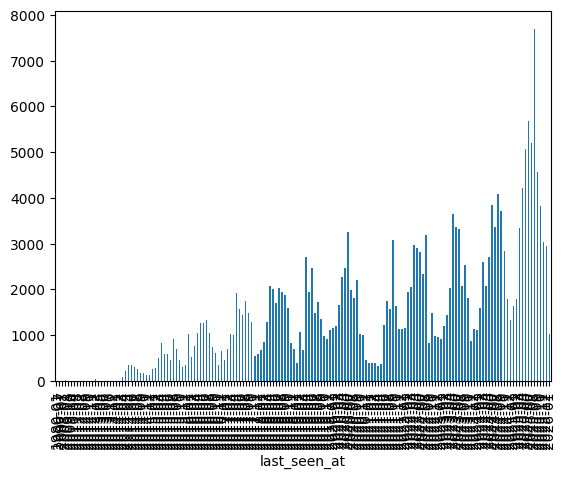

In [14]:
mapillary_trafficsigns_cw.last_seen_at.str[:-3].value_counts().sort_index().plot(kind="bar")


#### Zeitfilter 

In [16]:
##  is newer than 2025-01-01  

# september 2025: 36488
# oktober   2025: 41263
# november  2025: 45075
# dezember  2025: 47583
# januar    2026: 50015


mapillary_trafficsigns_cw=mapillary_trafficsigns_cw[mapillary_trafficsigns_cw["last_seen_at"] > "2025-01-01"]
# mapillary_trafficsigns_237_recent
len(mapillary_trafficsigns_cw)

50015

In [17]:
mapillary_trafficsigns_cw

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y
8100,POINT (8.64155 49.62652),2026-01-02,1204988208251213,2026-01-02,regulatory--shared-path-pedestrians-and-bicycl...,8585,5582
8104,POINT (8.64189 49.63115),2026-01-02,1391335725971588,2026-01-02,regulatory--shared-path-pedestrians-and-bicycl...,8585,5582
8110,POINT (8.64126 49.63632),2026-01-02,1383142483271536,2026-01-02,regulatory--dual-path-bicycles-and-pedestrians...,8585,5582
8113,POINT (8.64142 49.63644),2026-01-02,1383142479938203,2026-01-02,regulatory--dual-path-bicycles-and-pedestrians...,8585,5582
8119,POINT (8.6413 49.63715),2026-01-02,1383142476604870,2026-01-02,regulatory--bicycles-only--g1,8585,5582
...,...,...,...,...,...,...,...
6592814,POINT (10.21746 53.48556),2025-06-28,1857602711484402,2025-06-28,regulatory--bicycles-only--g1,8657,5300
6593493,POINT (10.24074 53.47726),2025-07-01,1215382157001367,2025-07-01,regulatory--shared-path-pedestrians-and-bicycl...,8658,5300
6593914,POINT (10.26062 53.40954),2025-08-10,756206870675626,2025-08-10,regulatory--shared-path-pedestrians-and-bicycl...,8658,5305
6593986,POINT (10.275 53.43165),2021-04-03,513621776748879,2025-10-19,regulatory--shared-path-pedestrians-and-bicycl...,8659,5304


<Axes: xlabel='last_seen_at'>

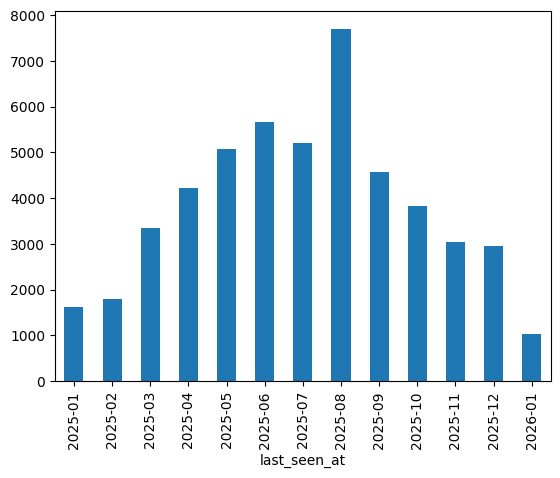

In [18]:
mapillary_trafficsigns_cw.last_seen_at.str[:-3].value_counts().sort_index().plot(kind="bar")


In [19]:
##  at least 12 months between first and last seen (to avoid temporary signs)
## might need to adjust this


zeitspanne = 9

def months_between(date1, date2):
    d1 = datetime.strptime(date1, "%Y-%m-%d")
    d2 = datetime.strptime(date2, "%Y-%m-%d")
    return abs((d2.year - d1.year) * 12 + d2.month - d1.month)

mapillary_trafficsigns_cw_temp = mapillary_trafficsigns_cw[
    mapillary_trafficsigns_cw.apply(lambda row: months_between(row['first_seen_at'], row['last_seen_at']) >= zeitspanne, axis=1)
]
len(mapillary_trafficsigns_cw_temp)

19410

<Axes: xlabel='last_seen_at'>

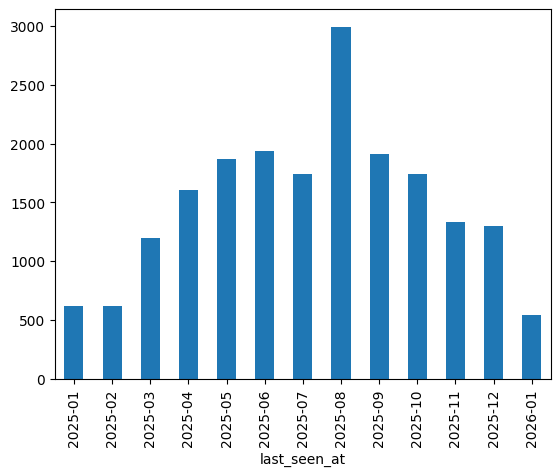

In [20]:
mapillary_trafficsigns_cw_temp.last_seen_at.str[:-3].value_counts().sort_index().plot(kind="bar")



<Axes: >

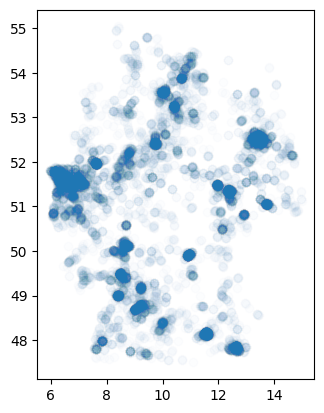

In [21]:
mapillary_trafficsigns_cw_temp.plot(alpha=0.01)

#### Räumliche Prüfung 

In [22]:
## now create a buffer around the traffic signs to check if there is a cycleway nearby
df_buffered_30 = mapillary_trafficsigns_cw_temp.to_crs(25833).copy()
df_buffered_25 = mapillary_trafficsigns_cw_temp.to_crs(25833).copy()

#df_buffered["geometry"] = df_buffered.geometry.buffer(50)
#df_buffered["geometry"] = df_buffered.geometry.buffer(40)
df_buffered_30["geometry"] = df_buffered_30.geometry.buffer(30)
df_buffered_25["geometry"] = df_buffered_25.geometry.buffer(25)


df_buffered_30 = df_buffered_30.to_crs(mapillary_trafficsigns_cw_temp.crs)
df_buffered_25 = df_buffered_25.to_crs(mapillary_trafficsigns_cw_temp.crs)


In [23]:
# helper 
def mark_intersections(buffered_df, target_layer, column_name="has_intersection"):
    """
    Marks which geometries in `buffered_df` intersect with `target_layer`.

    Parameters:
    - buffered_df (GeoDataFrame): The GeoDataFrame containing buffered geometries.
    - target_layer (GeoDataFrame): The GeoDataFrame to check for intersections (e.g., cycleways, motorways).
    - column_name (str): Name of the column to add/overwrite in `buffered_df` indicating intersection (bool).

    Returns:
    - GeoDataFrame: `buffered_df` with a new boolean column `column_name`.
    """
    # Ensure CRS matches
    buffered_df = buffered_df.to_crs(target_layer.crs)

    # Perform spatial join to find intersecting geometries
    joined = gpd.sjoin(buffered_df, target_layer, how="inner", predicate="intersects")

    # Initialize the new column to False
    buffered_df[column_name] = False

    # Set True for geometries that intersect
    matches = joined.index.unique()
    buffered_df.loc[matches, column_name] = True

    return buffered_df


In [24]:
# For cycleways
df_buffered_30 = mark_intersections(df_buffered_30, filtered_cycleways, column_name="has_cw_intersection")
df_buffered_25 = mark_intersections(df_buffered_25, filtered_cycleways, column_name="has_cw_intersection")



# For motorways (just 30m for both)
df_buffered_30 = mark_intersections(df_buffered_30, motorways, column_name="has_mw_intersection")
#df_buffered_20 = mark_intersections(df_buffered_30, motorways, column_name="has_mw_intersection")



In [25]:
df_buffered_30["buffer_size"] = 30
df_buffered_25["buffer_size"] = 25

In [26]:
#df_buffered.id.unique()

In [27]:
# An wie vielen Schilder ist ein Radweg in der Nähe?
df_buffered_30.has_cw_intersection.value_counts()

has_cw_intersection
True     19219
False      191
Name: count, dtype: int64

In [28]:
df_buffered_25.has_cw_intersection.value_counts()

has_cw_intersection
True     19190
False      220
Name: count, dtype: int64

In [29]:
# An wie vielen Schilder ist eine Autobahn in der Nähe?
df_buffered_30.has_mw_intersection.value_counts()

has_mw_intersection
False    19263
True       147
Name: count, dtype: int64

In [30]:
df_buffered_30.has_mw_intersection

8149       False
8345       False
8398       False
8399       False
8402       False
           ...  
6591589    False
6591601    False
6591609    False
6591634    False
6593986    False
Name: has_mw_intersection, Length: 19410, dtype: bool

In [31]:
df_buffered_25_false=df_buffered_25[(df_buffered_25.has_cw_intersection== False) & (df_buffered_30.has_mw_intersection== False)].copy()
len(df_buffered_25_false)

136

In [32]:
df_buffered_30_false=df_buffered_30[(df_buffered_30.has_cw_intersection== False) & (df_buffered_30.has_mw_intersection== False)].copy()
len(df_buffered_30_false)

107

In [33]:
df_buffered_25_false

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,buffer_size
28373,"POLYGON ((8.09987 50.10759, 8.09987 50.10756, ...",2018-09-24,295933305476601,2025-11-21,regulatory--bicycles-only--g1,8560,5548,False,25
118404,"POLYGON ((8.49211 50.0673, 8.49211 50.06727, 8...",2018-03-02,791855115085227,2025-06-08,regulatory--bicycles-only--g1,8578,5551,False,25
122015,"POLYGON ((8.48684 49.92968, 8.48685 49.92966, ...",2021-07-12,776249919711409,2025-07-13,regulatory--shared-path-pedestrians-and-bicycl...,8578,5561,False,25
179271,"POLYGON ((8.57422 49.97318, 8.57422 49.97315, ...",2024-08-14,859064379196100,2025-05-03,regulatory--shared-path-pedestrians-and-bicycl...,8582,5558,False,25
183148,"POLYGON ((8.58746 49.99864, 8.58746 49.99862, ...",2024-08-18,506136905440971,2025-05-16,regulatory--shared-path-pedestrians-and-bicycl...,8582,5556,False,25
...,...,...,...,...,...,...,...,...,...
6364707,"POLYGON ((13.49302 52.63668, 13.49302 52.63666...",2021-09-26,1061132341374293,2025-03-09,regulatory--bicycles-only--g1,8806,5364,False,25
6411084,"POLYGON ((13.56695 52.55124, 13.56695 52.55122...",2021-12-21,218873913750149,2025-05-30,regulatory--bicycles-only--g1,8809,5370,False,25
6418242,"POLYGON ((13.56779 52.45452, 13.56778 52.4545,...",2024-03-13,951249552801493,2025-05-20,regulatory--shared-path-pedestrians-and-bicycl...,8809,5378,False,25
6497616,"POLYGON ((9.98336 53.54789, 9.98337 53.54787, ...",2023-04-06,6466767800002742,2025-02-20,regulatory--bicycles-only--g1,8646,5295,False,25


In [34]:
df_buffered_both_false= pd.concat([df_buffered_30_false, df_buffered_25_false]).sort_values("buffer_size").drop_duplicates(subset=['id'],keep="last")
df_buffered_both_false["buffer_size"].value_counts()

buffer_size
30    107
25     29
Name: count, dtype: int64

priority bei MapRoulette:

| Wert | Bedeutung         |
| ---- | ----------------- |
| 0    | High              |
| 1    | Medium (Standard) |
| 2    | Low               |


In [35]:
df_buffered_both_false["prio"] = df_buffered_both_false["buffer_size"].map({25: 1, 30: 0}).astype("Int64")

In [36]:
df_buffered_both_false

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection,buffer_size,prio
1411844,"POLYGON ((9.01222 48.67532, 9.01222 48.67529, ...",2023-10-28,981194446312339,2025-11-28,regulatory--shared-path-pedestrians-and-bicycl...,8602,5649,False,NaN,25,1
306069,"POLYGON ((8.67188 49.96108, 8.67188 49.96106, ...",2024-03-08,2228023380881004,2025-12-22,regulatory--bicycles-only--g1,8586,5559,False,NaN,25,1
462430,"POLYGON ((9.06172 51.20085, 9.06172 51.20083, ...",2023-01-24,2949974415147165,2025-12-14,regulatory--shared-path-pedestrians-and-bicycl...,8604,5470,False,NaN,25,1
5460086,"POLYGON ((12.97882 47.84199, 12.97882 47.84197...",2024-10-02,1643390686240585,2025-08-14,regulatory--bicycles-only--g1,8782,5706,False,NaN,25,1
5414542,"POLYGON ((12.65481 47.81831, 12.65481 47.81829...",2023-04-01,186190040875225,2025-08-14,regulatory--shared-path-pedestrians-and-bicycl...,8767,5707,False,NaN,25,1
...,...,...,...,...,...,...,...,...,...,...,...
2332835,"POLYGON ((13.52565 52.38994, 13.52564 52.38991...",2023-03-26,554611050095390,2025-04-12,regulatory--shared-path-pedestrians-and-bicycl...,8807,5382,False,False,30,0
2448403,"POLYGON ((13.24725 51.58353, 13.24725 51.5835,...",2024-04-03,432174662700131,2025-08-30,regulatory--shared-path-pedestrians-and-bicycl...,8794,5442,False,False,30,0
2474313,"POLYGON ((13.43439 52.87542, 13.43439 52.87539...",2024-10-21,1071412457919795,2025-10-03,regulatory--shared-path-pedestrians-and-bicycl...,8803,5346,False,False,30,0
2555179,"POLYGON ((13.88367 52.57707, 13.88367 52.57704...",2025-02-11,914064113927751,2025-11-04,regulatory--shared-path-pedestrians-and-bicycl...,8823,5368,False,False,30,0


In [37]:
# interactive map
# df_buffered_false.explore(
#     color="red",
#     tiles="CartoDB positron",
#     popup=True,
#     tooltip=["value", "first_seen_at", "last_seen_at"]
# )

In [38]:
import json
import requests

#### clean up from existing maproulette challenge

In [39]:
### import the the flagged (not created, fixed) tasks from the challenge. 

# challenge_gdf = gpd.read_file("challenge_52916_data_f_mr.geojson")
#challenge_gdf.head()

with open("../utils/config_mapillary_privat.json", "r") as f:
    config = json.load(f)
API_KEY = config["API_KEY_MAPROULETTE"]

CHALLENGE_ID = 52916
BASE_URL = "https://maproulette.org/api/v2"

headers = {"apiKey": API_KEY}

# Single request to get all tasks as GeoJSON
r = requests.get(
    f"{BASE_URL}/challenge/view/{CHALLENGE_ID}",
    headers=headers
)
r.raise_for_status()
geojson_data = r.json()

# Convert directly to GeoDataFrame
challenge_gdf = gpd.GeoDataFrame.from_features(geojson_data, crs='EPSG:4326')

challenge_gdf=challenge_gdf[~challenge_gdf.mr_taskStatus.isin(["Fixed", "Created", "Skipped"])]

df_buffered_both_false = df_buffered_both_false.to_crs(4326)

# Find intersections
intersections = gpd.sjoin(df_buffered_both_false, challenge_gdf, how="left", predicate="intersects")

# Keep only rows that do NOT intersect (i.e., no match in challenge_gdf)
df_buffered_both_false_no_challenge = df_buffered_both_false.loc[intersections.index[intersections["index_right"].isna()]] 

len(df_buffered_both_false_no_challenge)


77

### retrieve the image ID for the map features

In [40]:
#df_process_img= df_buffered_false.copy()
df_process_img= df_buffered_both_false_no_challenge.copy()

In [41]:
import sys
import os
import json
import logging
from contextlib import contextmanager
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# ---------------------------------------------------------------


# -- suppress stdout context manager --
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# -- Load config & set Mapillary token --
with open("config_mapillary_privat.json", "r") as f:
    config = json.load(f)

access_token = config["ACCESS_TOKEN"]
mly.interface.set_access_token(access_token)

# -- Logging cleanup --
for name in logging.root.manager.loggerDict:
    logging.getLogger(name).setLevel(logging.WARNING)
logging.basicConfig(level=logging.ERROR)

# -- Your image fetching function --
def get_image_id(map_feature_id):
    try:
        feature_str = mly.interface.feature_from_key(key=str(map_feature_id))
        feature = json.loads(feature_str)
        images = feature["features"]["properties"]["images"]["data"]
        return images[-1]["id"] if images else None
    except Exception as e:
        return None  # Or log the error if needed

# -- Parallelized version using ThreadPoolExecutor --
def parallel_get_image_ids(ids, max_workers=8):
    results = [None] * len(ids)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(get_image_id, id_): idx for idx, id_ in enumerate(ids)}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Fetching image IDs"):
            idx = futures[future]
            try:
                results[idx] = future.result()
            except Exception:
                results[idx] = None  # Or log
    return results

# -- Apply to your dataframe --
with suppress_stdout():
    df_process_img["image_id"] = parallel_get_image_ids(df_process_img["id"].tolist(), max_workers=5)  # Adjust max_workers as needed, 5 is fastest for me


Fetching image IDs: 100%|██████████| 77/77 [00:13<00:00,  5.72it/s]


In [42]:
## https://www.mapillary.com/app/?pKey=1029316554880692

df_process_img.head()



,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection,buffer_size,prio,image_id
1411844,"POLYGON ((9.01222 48.67532, 9.01222 48.67529, ...",2023-10-28,981194446312339,2025-11-28,regulatory--shared-path-pedestrians-and-bicycl...,8602,5649,False,NaN,25,1,300273559482881
306069,"POLYGON ((8.67188 49.96108, 8.67188 49.96106, ...",2024-03-08,2228023380881004,2025-12-22,regulatory--bicycles-only--g1,8586,5559,False,NaN,25,1,377160551800880
462430,"POLYGON ((9.06172 51.20085, 9.06172 51.20083, ...",2023-01-24,2949974415147165,2025-12-14,regulatory--shared-path-pedestrians-and-bicycl...,8604,5470,False,NaN,25,1,605855934707319
5460086,"POLYGON ((12.97882 47.84199, 12.97882 47.84197...",2024-10-02,1643390686240585,2025-08-14,regulatory--bicycles-only--g1,8782,5706,False,NaN,25,1,1105811517573019
5114102,"POLYGON ((11.62125 48.22315, 11.62125 48.22313...",2024-12-14,1518764388839119,2025-11-03,regulatory--shared-path-pedestrians-and-bicycl...,8720,5680,False,NaN,25,1,2871342523172441


In [43]:
# to points, to 4326

centroids = df_process_img.copy()
centroids=centroids.to_crs(25832)
centroids["geometry"] = centroids.geometry.centroid
centroids=centroids.to_crs(4326)

centroids.sort_values("last_seen_at")


,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection,buffer_size,prio,image_id
6364707,POINT (13.49265 52.63668),2021-09-26,1061132341374293,2025-03-09,regulatory--bicycles-only--g1,8806,5364,False,NaN,25,1,858072038413968
1714832,POINT (9.54681 48.6668),2019-12-16,1211575312646971,2025-04-11,regulatory--shared-path-pedestrians-and-bicycl...,8626,5649,False,False,30,0,296347838658895
2332835,POINT (13.52521 52.38993),2023-03-26,554611050095390,2025-04-12,regulatory--shared-path-pedestrians-and-bicycl...,8807,5382,False,False,30,0,1172816643425424
3873842,POINT (7.03065 51.53321),2021-09-20,170297258607479,2025-04-15,regulatory--bicycles-only--g1,8511,5446,False,NaN,25,1,203095655255854
4283899,POINT (7.71867 51.18553),2024-05-26,986734396457268,2025-05-11,regulatory--shared-path-pedestrians-and-bicycl...,8543,5471,False,NaN,25,1,1230656268373276
...,...,...,...,...,...,...,...,...,...,...,...,...
1551068,POINT (9.22496 49.19719),2023-08-01,1336070107342783,2025-12-29,regulatory--shared-path-pedestrians-and-bicycl...,8611,5612,False,False,30,0,300874059062289
3079470,POINT (10.4176 53.2685),2024-05-09,1489130531962126,2026-01-06,regulatory--dual-path-bicycles-and-pedestrians...,8666,5316,False,False,30,0,1370527700249958
3079474,POINT (10.4174 53.2692),2015-08-10,307889280892543,2026-01-06,regulatory--dual-path-bicycles-and-pedestrians...,8666,5316,False,False,30,0,822234702006056
1679839,POINT (9.41109 48.81742),2020-05-15,485105259361762,2026-01-15,regulatory--shared-path-pedestrians-and-bicycl...,8620,5639,False,False,30,0,184028336923099


In [44]:
# Mapping dictionary
value_to_vz = {
    'regulatory--dual-path-pedestrians-and-bicycles--g1': 241,
    'regulatory--dual-path-bicycles-and-pedestrians--g1': 241,
    'regulatory--bicycles-only--g1': 237,
    'regulatory--shared-path-pedestrians-and-bicycles--g1': 240
}

# Add new column based on mapping
centroids["VZ"] = centroids["value"].map(value_to_vz)

In [45]:
#centroids

In [46]:
centroids

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection,buffer_size,prio,image_id,VZ
1411844,POINT (9.01188 48.6753),2023-10-28,981194446312339,2025-11-28,regulatory--shared-path-pedestrians-and-bicycl...,8602,5649,False,NaN,25,1,300273559482881,240
306069,POINT (8.67153 49.96106),2024-03-08,2228023380881004,2025-12-22,regulatory--bicycles-only--g1,8586,5559,False,NaN,25,1,377160551800880,237
462430,POINT (9.06136 51.20083),2023-01-24,2949974415147165,2025-12-14,regulatory--shared-path-pedestrians-and-bicycl...,8604,5470,False,NaN,25,1,605855934707319,240
5460086,POINT (12.97849 47.84199),2024-10-02,1643390686240585,2025-08-14,regulatory--bicycles-only--g1,8782,5706,False,NaN,25,1,1105811517573019,237
5114102,POINT (11.62092 48.22314),2024-12-14,1518764388839119,2025-11-03,regulatory--shared-path-pedestrians-and-bicycl...,8720,5680,False,NaN,25,1,2871342523172441,240
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260844,POINT (14.38408 51.05374),2023-03-19,1387156338785659,2025-12-12,regulatory--shared-path-pedestrians-and-bicycl...,8846,5481,False,False,30,0,6055917691127885,240
2260849,POINT (14.38055 51.05409),2023-03-19,1387156335452326,2025-12-12,regulatory--shared-path-pedestrians-and-bicycl...,8846,5481,False,False,30,0,994044018646658,240
2268773,POINT (14.62942 50.99734),2017-08-02,477902856827040,2025-12-14,regulatory--shared-path-pedestrians-and-bicycl...,8857,5485,False,False,30,0,1058710947950938,240
2332835,POINT (13.52521 52.38993),2023-03-26,554611050095390,2025-04-12,regulatory--shared-path-pedestrians-and-bicycl...,8807,5382,False,False,30,0,1172816643425424,240


In [47]:
centroids["prio_text"] = centroids["prio"].map({
    0: "🟩 Task mit hoher Wahrscheinlichkeit valide",
    1: "🟨 Task mit mittlerer Wahrscheinlichkeit valide",
    2: "🟥 Task mit eher geringer Wahrscheinlichkeit valide"
})

centroids[["prio", "prio_text"]].head()

,prio,prio_text
1411844,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide
306069,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide
462430,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide
5460086,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide
5114102,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide


In [48]:
#centroids.plot()

In [49]:
import uuid

def to_maproulette_geojson_with_links(gdf, id_field="id", name_field="value", image_field="image_id"):
    features = []

    for _, row in gdf.iterrows():
        geom = row.geometry
        centroid = geom.centroid
        lat, lon = round(centroid.y, 6), round(centroid.x, 6)

        # Optional: Mapillary image
        image_url = None
        image_id = None
        if pd.notna(row.get(image_field)):
            image_id = str(int(row[image_field]))
            image_url = (
                f"https://www.mapillary.com/app/?pKey={image_id}"
                "&focus=photo"
                "&trafficSign[]=regulatory--bicycles-only--g1"
                "&trafficSign[]=regulatory--shared-path-pedestrians-and-bicycles--g1"
                "&trafficSign[]=regulatory--dual-path-bicycles-and-pedestrians--g1"
                "&trafficSign[]=regulatory--dual-path-pedestrians-and-bicycles--g1"
            )

        # TILDA link
        tilda_url = f"https://tilda-geo.de/regionen/radinfra?map=17.4/{lat}/{lon}&config=pdqyyt.7h3d.16g9vk&v=2&data=mapillary-cycleway-traffic-signs"

#         # Build instruction
        instruction = f"""  
### 🚧 Aufgabe: Verkehrszeichen **DE:{row["VZ"]}** überprüfen und Radinfra hinzufügen
Bitte schaue dir den Bereich rund um dieses erkannte Verkehrszeichen an. Vermutlich fehlt hier eine Radinfrastruktur, die du hinzufügen kannst. Die nächste OSM-Radinfra ist mind. **{row["buffer_size"]} Meter** entfernt.

---

### 🖼️ Bild & Karte

- 📷 [**Mapillary-Bild anzeigen**]({image_url})  
(Hinweis: Das zuerst angezeigte Bild ist wahrscheinlich nicht das neueste – die neueste Aufnahme hier ist von **{row["last_seen_at"]})**

- 🗺️ [**In radinfra.de bzw TILDA ansehen**]({tilda_url})  
(Hinweis: Ist hilfreich um den aktuellen Stand der Radinfrastruktur vor Ort zu prüfen.)

---

### 📚 Nützliche Links

- 🛑 [**Traffic Sign Tool** – DE:{row["VZ"]}](https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:{row["VZ"]})  
- 🚴 [**OSM-Wiki: Radverkehrsanlagen kartieren**](https://wiki.openstreetmap.org/wiki/DE:Bicycle/Radverkehrsanlagen_kartieren)

---

Viel Erfolg beim Prüfen und Mappen! 🗺️
        """

        # Build properties
        props = {
            #"identifier": str(row[id_field]),
            "image_id": image_id,
            "Verkehrzeichen": str(row["VZ"]),
            "instruction": instruction,   #.strip(),
            "priority":  row["prio"],
            "name": row["prio_text"]
        }

        # Build feature
        feature = {
            "type": "Feature",
            "geometry": row["geometry"].__geo_interface__,
            "properties": props,
            # Set the top-level ID here
            "id":  str(row[id_field]), # detection Id
           # "priority":  row["prio"] 
        }

        # # Add Mapillary attachment if available
        # if image_id:
        #     feature["attachments"] = [
        #         {
        #             "id": str(uuid.uuid4()),
        #             "kind": "referencePhoto",
        #             "type": "mapillary",
        #             "format": "image",
        #             "data": image_id
        #         }
        #     ]

        features.append(feature)

    return {
        "type": "FeatureCollection",
        "features": features
    }


In [50]:
# Convert your df_buffered_false (or any GeoDataFrame) to GeoJSON
maproulette_geojson = to_maproulette_geojson_with_links(centroids)

# Save to file
with open("maproulette_tasks_missing-cw_instruction_vz_name_new.geojson", "w") as f:
    json.dump(maproulette_geojson, f, indent=2)


In [ ]:
### Maproulette stuff....

In [ ]:
## Add missing cycleways based on mapillary signs (Germany)


## 🚲 Fehlende Radwege anhand von Mapillary-Verkehrszeichen ergänzen (Deutschland)

Diese Challenge basiert auf automatisch erkannten, radverkehrsbezogenen Verkehrszeichen aus Mapillary-Bildern in Deutschland.

### 📌 Kriterien für jede Aufgabe

Nur Aufgaben, die **alle** folgenden Bedingungen erfüllen, wurden berücksichtigt:

- Das Verkehrszeichen wurde **in Mapillary erkannt**.
- Es handelt sich um ein **radverkehrsbezogenes Zeichen**  
  *(z. B. gemeinsamer Geh- und Radweg, reiner Radweg, getrennter Geh-/Radweg)*.
- Das Zeichen wurde **mindestens 12 Monate lang regelmäßig gesehen**.
- Die neuste Aufnahme stammt **aus dem Jahr 2025**.
- Es existiert **kein OSM-"Radweg" innerhalb von 30 m** des Standortes.

---

### 🔍 Was du tun solltest

1. Öffne den Ort in **Mapillary** und **radinfra.de** sowie einem Editor.
2. Prüfe, ob an der Stelle eine **Radinfrastruktur fehlt**.
3. Falls ja, ergänze die passenden OSM-Tags:  
   z. B. `highway=cycleway`, `cycleway=*`, `bicycle=designated`, etc.
4. Wenn bereits alles korrekt gemappt ist, kannst du die Aufgabe einfach **als erledigt markieren**.

---

🗺️ Vielen Dank für deine Hilfe beim Ausbau der Radinfrastruktur in OSM!

In [ ]:
'''
{{instruction}}
                                                                                             .
'''